# Light GBMで予測した結果を用いて実際にbetをした場合の回収率をシミュレート

## 1. データ準備

### 1.1　1-6号艇のRankに対するモデルの予測値をdfに格納

In [1]:
import pandas as pd
import glob
import os

# 1.1.1 データロード
input_folderpath = '../2_データ解析/210411_過去成績を追加_3'

test_predict_proba_df_list = [pd.read_pickle(file).set_index(
    ["date", "venue", "raceNumber"]) for file in glob.glob(
    (os.path.join(input_folderpath, 'predict_proba_test_frame_*.pkl')))
                        ]

train_predict_proba_df_list = [pd.read_pickle(file).set_index(
    ["date", "venue", "raceNumber"]) for file in glob.glob(
    (os.path.join(input_folderpath, 'predict_proba_train_frame_*.pkl')))
                        ]

# 1.1.2 データ統合
test_predict_proba_df = pd.concat(test_predict_proba_df_list, axis=1)
train_predict_proba_df = pd.concat(train_predict_proba_df_list, axis=1)

In [2]:
# 確認用
test_predict_proba_df

predict_proba_frame_1  predict_proba_frame_2  \
date       venue raceNumber                                                 
2021-03-30 大　村   4.0                      0.408059               0.476554   
                 5.0                      0.389748               0.590147   
                 6.0                      0.517948               0.688868   
                 7.0                      0.534602               0.431149   
                 8.0                      0.502868               0.430877   
...                                            ...                    ...   
2021-04-06 蒲　郡   8.0                      0.441742               0.384382   
                 9.0                      0.541294               0.608540   
                 10.0                     0.664418               0.377342   
                 11.0                     0.652771               0.527618   
                 12.0                     0.597437               0.422676   

                             predict_proba_frame_3  predict_proba_frame_6  \
date       venue raceNumber                                                 
2021-03-30 大　村   4.0                      0.504185               0.565822   
                 5.0                      0.570330               0.373035   
                 6.0                      0.334052               0.522535   
                 7.0                      0.547249               0.263462   
                 8.0                      0.620192               0.741180   
...                                            ...                    ...   
2021-04-06 蒲　郡   8.0                      0.617219               0.563780   
                 9.0                      0.383213               0.425077   
                 10.0                     0.603670               0.460937   
                 11.0                     0.504316               0.517485   
                 12.0                     0.663566               0.253299   

                             predict_proba_frame_4  predict_proba_frame_5  
date       venue raceNumber                                                
2021-03-30 大　村   4.0                      0.395403               0.570467  
                 5.0                      0.389860               0.596008  
                 6.0                      0.424372               0.658798  
                 7.0                      0.637650               0.429026  
                 8.0                      0.435040               0.274049  
...                                            ...                    ...  
2021-04-06 蒲　郡   8.0                      0.622451               0.378054  
                 9.0                      0.524623               0.650869  
                 10.0                     0.475966               0.582621  
                 11.0                     0.588310               0.422920  
                 12.0                     0.610471               0.522883  

[936 rows x 6 columns]

### 1.2　上記のdfに当たり番号と払戻金を追加

In [3]:
# 1.2.1 データロード
win_and_pay_df = pd.read_pickle('../../data/arrangedData/win_and_pay_df.pkl')

# concatするためにraceNumberのindexをint型に
win_and_pay_df = win_and_pay_df.reset_index()
win_and_pay_df = win_and_pay_df.set_index(["date", "venue", "raceNumber"])
win_and_pay_df

3連単  3連単odds    3連複  3連複odds  2連単  2連単odds  \
date       venue raceNumber                                                 
2020-11-03 桐　生   1.0         1-4-3     3540  1-3-4     1000  1-4      960   
                 2.0         1-5-3     1610  1-3-5      470  1-5      580   
                 3.0         1-3-4      660  1-3-4      320  1-3      310   
                 4.0         2-3-1     9270  1-2-3      320  2-3     3710   
                 5.0         1-3-6     6400  1-3-6     4000  1-3      800   
...                            ...      ...    ...      ...  ...      ...   
2020-11-26 福　岡   8.0         1-4-5     1520  1-4-5      860  1-4      440   
                 9.0         4-2-1     4590  1-2-4      320  4-2     1440   
                 10.0        1-6-4     5120  1-4-6      540  1-6     1870   
                 11.0        3-4-2    43480  2-3-4     6300  3-4    11890   
                 12.0        2-4-3    21820  2-3-4     2450  2-4     7180   

                             2連複  2連複odds 拡連複_1  拡連複odds_1 拡連複_2  拡連複odds_2  \
date       venue raceNumber                                                   
2020-11-03 桐　生   1.0         1-4      950   1-4        450   1-3        200   
                 2.0         1-5      600   1-5        190   1-3        130   
                 3.0         1-3      250   1-3        120   1-4        140   
                 4.0         2-3     1590   2-3        180   1-2        170   
                 5.0         1-3      670   1-3        290   1-6        450   
...                          ...      ...   ...        ...   ...        ...   
2020-11-26 福　岡   8.0         1-4      460   1-4        190   1-5        210   
                 9.0         2-4      570   2-4        200   1-4        280   
                 10.0        1-6     1480   1-6        470   1-4        210   
                 11.0        3-4     3570   3-4        930   2-3        640   
                 12.0        2-4     2340   2-4        990   2-3        670   

                            拡連複_3  拡連複odds_3 単勝  単勝odds 複勝_1  複勝odds_1 複勝_2  \
date       venue raceNumber                                                   
2020-11-03 桐　生   1.0          3-4        420  1     190    1       120    4   
                 2.0          3-5        390  1     110    1       150    5   
                 3.0          3-4        180  1     130    1       210    3   
                 4.0          1-3        160  2    1290    2       360    3   
                 5.0          3-6       1840  1     140    1       130    3   
...                           ...        ... ..     ...  ...       ...  ...   
2020-11-26 福　岡   8.0          4-5        660  1     100    1       100    4   
                 9.0          1-2        140  4     590    4       120    2   
                 10.0         4-6        470  1     140    1       150    6   
                 11.0         2-4        450  3     640    3       590    4   
                 12.0         3-4        250  2     760    2       580    4   

                             複勝odds_2  
date       venue raceNumber            
2020-11-03 桐　生   1.0              360  
                 2.0              300  
                 3.0              380  
                 4.0              160  
                 5.0              660  
...                               ...  
2020-11-26 福　岡   8.0              180  
                 9.0              110  
                 10.0             660  
                 11.0            1450  
                 12.0             580  

[28040 rows x 20 columns]

In [4]:
for_simulate_df = pd.merge(test_predict_proba_df, win_and_pay_df, how="inner", left_index=True, right_index=True)
for_simulate_df

predict_proba_frame_1  predict_proba_frame_2  \
date       venue raceNumber                                                 
2021-03-30 大　村   4.0                      0.408059               0.476554   
                 5.0                      0.389748               0.590147   
                 6.0                      0.517948               0.688868   
                 7.0                      0.534602               0.431149   
                 8.0                      0.502868               0.430877   
...                                            ...                    ...   
2021-04-06 蒲　郡   8.0                      0.441742               0.384382   
                 9.0                      0.541294               0.608540   
                 10.0                     0.664418               0.377342   
                 11.0                     0.652771               0.527618   
                 12.0                     0.597437               0.422676   

                             predict_proba_frame_3  predict_proba_frame_6  \
date       venue raceNumber                                                 
2021-03-30 大　村   4.0                      0.504185               0.565822   
                 5.0                      0.570330               0.373035   
                 6.0                      0.334052               0.522535   
                 7.0                      0.547249               0.263462   
                 8.0                      0.620192               0.741180   
...                                            ...                    ...   
2021-04-06 蒲　郡   8.0                      0.617219               0.563780   
                 9.0                      0.383213               0.425077   
                 10.0                     0.603670               0.460937   
                 11.0                     0.504316               0.517485   
                 12.0                     0.663566               0.253299   

                             predict_proba_frame_4  predict_proba_frame_5  \
date       venue raceNumber                                                 
2021-03-30 大　村   4.0                      0.395403               0.570467   
                 5.0                      0.389860               0.596008   
                 6.0                      0.424372               0.658798   
                 7.0                      0.637650               0.429026   
                 8.0                      0.435040               0.274049   
...                                            ...                    ...   
2021-04-06 蒲　郡   8.0                      0.622451               0.378054   
                 9.0                      0.524623               0.650869   
                 10.0                     0.475966               0.582621   
                 11.0                     0.588310               0.422920   
                 12.0                     0.610471               0.522883   

                               3連単  3連単odds    3連複  3連複odds  ... 拡連複_2  \
date       venue raceNumber                                  ...         
2021-03-30 大　村   4.0         2-5-4    27460  2-4-5     6360  ...   2-4   
                 5.0         2-3-4     6660  2-3-4     2860  ...   2-4   
                 6.0         2-1-5      680  1-2-5      200  ...   2-5   
                 7.0         1-4-2      750  1-2-4      290  ...   1-2   
                 8.0         3-1-6      770  1-3-6      200  ...   3-6   
...                            ...      ...    ...      ...  ...   ...   
2021-04-06 蒲　郡   8.0         1-3-5     3590  1-3-5     1600  ...   1-5   
                 9.0         4-5-6    15450  4-5-6     6670  ...   4-6   
                 10.0        1-2-3     1080  1-2-3      430  ...   1-3   
                 11.0        4-1-2     2350  1-2-4      300  ...   2-4   
                 12.0        1-3-4      470  1-3-4      200  ...   1-4   

                             拡連複odds_2 拡連複_3  拡連複odds_3 単勝  

## 2. シミュレート

### 2.1 predicted valueが基準値を満たす艇を有望な艇としてピックアップ

In [5]:
def make_good_frame_list(for_simulate_df, thresholds_list):
    """
    thresholdを満たす艇番号をリストにしてdfの列に追加するための関数
    """
    
    good_frame_list = [] # thresholdを満たす艇番号をlistに格納
    
    for i in range(6):
        if for_simulate_df["predict_proba_frame_{0}".format(i+1)] > thresholds_list[i]:
            good_frame_list.append(i+1)
    
    return good_frame_list
    
# --- input --- 

# the_thresholds_list: predict probabilityが1に近いとみなすthresholdのリスト。6つの要素を持つリスト
the_thresholds_list = [0.6 for j in range(6)]

# -------------

# predict probabilityがthresholdを超えている枠番のリストを作成し、dfに追加
for_simulate_df["good_frame_list"] = for_simulate_df.apply(
    make_good_frame_list,
    thresholds_list=the_thresholds_list,
    axis=1)

### 2.2 賭け方を指定.
今回は、1号艇が基準値を超えており、かつ2-6号艇の中に基準値を超える艇が2艇以上あった場合、1-(BOX)の形で3連単にbetする
betする番号のリストの列を作成して格納

In [6]:
def make_bed_list_trifecta(good_frame_list):
    """
    good_rame_listから、3連単でbetする番号のリストを作成
    """
    bet_list_trifecta = []
    
    # good frame listの、2-6枠のリストの中から2つの艇番号をpickして順列を作成
    for i in range(len(good_frame_list) - 1):
        
        for j in range(len(good_frame_list) - 1):
            if j == i:
                pass
            else:
                bet_list_trifecta.append("1-{0}-{1}".format(good_frame_list[i+1],
                                                            good_frame_list[j+1])
                                        )
    
    return bet_list_trifecta


# リストの長さが3以上はないと投票対象にはならない
for_simulate_df_bet = for_simulate_df[(for_simulate_df["good_frame_list"
                                                      ].map(lambda x: len(x)) >= 3)]
# リストの1番目の数字が1であるもののみが投票対象
for_simulate_df_bet = for_simulate_df_bet[for_simulate_df_bet["good_frame_list"
                                                             ].map(lambda x: x[0]==1)]
# 投票番号の列を作成
for_simulate_df_bet["bet_list_trifecta"] = for_simulate_df_bet["good_frame_list"
                                                              ].apply(make_bed_list_trifecta)

for_simulate_df_bet

predict_proba_frame_1  predict_proba_frame_2  \
date       venue raceNumber                                                 
2021-03-30 常　滑   12.0                     0.702734               0.440183   
           徳　山   11.0                     0.652771               0.602699   
           浜名湖   12.0                     0.624493               0.607540   
           若　松   8.0                      0.618359               0.623115   
           蒲　郡   10.0                     0.630833               0.618601   
2021-03-31 　津　   6.0                      0.602008               0.620752   
           丸　亀   11.0                     0.621469               0.526620   
           多摩川   12.0                     0.603356               0.655219   
           宮　島   12.0                     0.608945               0.643479   
           尼　崎   12.0                     0.632712               0.643588   
           芦　屋   4.0                      0.640026               0.604565   
           若　松   8.0                      0.602220               0.655856   
2021-04-01 住之江   3.0                      0.613015               0.596135   
                 5.0                      0.622790               0.637515   
                 7.0                      0.633526               0.619917   
                 9.0                      0.627254               0.637382   
           唐　津   12.0                     0.728744               0.605160   
           戸　田   10.0                     0.677051               0.604565   
2021-04-02 住之江   11.0                     0.640026               0.636272   
           唐　津   4.0                      0.622790               0.337193   
           大　村   9.0                      0.646204               0.618181   
2021-04-03 　津　   12.0                     0.640026               0.636971   
           丸　亀   12.0                     0.616445               0.611800   
           住之江   6.0                      0.633526               0.612130   
                 9.0                      0.634703               0.614124   
                 10.0                     0.664081               0.613590   
           常　滑   4.0                      0.613913               0.445470   
           戸　田   12.0                     0.622790               0.637360   
           浜名湖   11.0                     0.623242               0.657596   
2021-04-04 丸　亀   11.0                     0.670564               0.543959   
           住之江   4.0                      0.627170               0.602980   
                 5.0                      0.610987               0.620493   
                 12.0                     0.627254               0.626662   
           宮　島   7.0                      0.624091               0.611800   
                 9.0                      0.640026               0.607088   
           常　滑   4.0                      0.623242               0.669504   
                 11.0                     0.633973               0.431976   
2021-04-05 住之江   9.0                      0.664081               0.612312   
           児　島   8.0                      0.625766               0.446606   
           福　岡   4.0                      0.680469               0.418328   
           芦　屋   12.0                     0.624091               0.616976   
2021-04-06 三　国   12.0                     0.629881               0.567065   
           住之江   3.0                      0.630385               0.613919   
                 9.0                      0.646204               0.611800   
                 10.0                     0.605976               0.568912   
           宮　島   1.0                      0.616445               0.637183   
                 4.0                      0.652771               0.620217   
                 6.0                      0.652771               0.632893   
                 10.0                     0.640026               0.626698   
                 11.0                     0.610239               0.616799   

                        

### 2.3 betした場合の収支を計算
- 収入と支出それぞれを新しい列として追加する

In [7]:
def calc_income(for_simulate_df_bet):
    # 今後trifecta以外でも使えるように拡張したいがとりあえず3連単限定で作成
    if for_simulate_df_bet["3連単"] in for_simulate_df_bet["bet_list_trifecta"]:
        income = for_simulate_df_bet["3連単odds"]
    else:
        income = 0
        
    return income
    
for_simulate_df_bet["outcome"] = for_simulate_df_bet["bet_list_trifecta"].apply(lambda x: len(x) * 100)
for_simulate_df_bet["income"] = for_simulate_df_bet.apply(calc_income, axis=1)

print("賭け金合計は{0}円".format(for_simulate_df_bet["outcome"].sum()))
print("払戻し合計は{0}円".format(for_simulate_df_bet["income"].sum()))



賭け金合計は10800円
払戻し合計は11430円


### 2.4 結果を図示

<AxesSubplot:xlabel='date,venue,raceNumber'>

/Users/grice/opt/anaconda3/envs/boatrace2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/grice/opt/anaconda3/envs/boatrace2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/grice/opt/anaconda3/envs/boatrace2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/grice/opt/anaconda3/envs/boatrace2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 33446 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/grice/opt/anaconda3/envs/boatrace2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23627 missing from current font.
  font.set_text(s, 0.0, fla

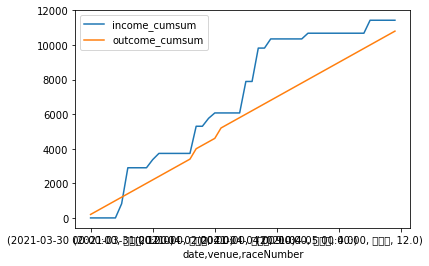

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
for_simulate_df_bet[["income_cumsum", "outcome_cumsum"]] = for_simulate_df_bet[["income", "outcome"]].cumsum()

for_simulate_df_bet[["income_cumsum", "outcome_cumsum"]].plot()